In [18]:
import os
from os import listdir
from os.path import isfile, join

from datetime import datetime

import pandas as pd

import warnings
import numpy as np
import matplotlib.pyplot as plt

import rasterio
import rasterio.mask


from rasterio.plot import show
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping

import glob
import xarray as xr 
import rioxarray as rio

## .NC to .TIF

In [19]:
import os
#imgList =glob.glob('./data/tp_final/grupo_8/raw_data/L2/L3_nc/*.nc')
imgList = glob.glob('./data/raw_data/L3_nc/*.nc')
outpath = './datos/proc/'
imgList[1]

'./data/raw_data/L3_nc/L3m_20200125-20200201__561568769_4_AVW-MODVIR_CHL1_8D_00.nc'

In [20]:
for img in imgList:
    xds = xr.open_dataset(img)
    xds.rio.write_crs("epsg:4326", inplace=True)
    xds["CHL1_mean"].rio.to_raster(img.replace('.nc','.tif'))

## Defino funciones de utilidad 

In [21]:
def guardar_GTiff(fn,crs,transform,mat):
        if len(mat.shape)==2:
            count=1
        else:
            count=mat.shape[0]
        with rasterio.open(
        fn,
        'w',
        driver='GTiff',
        height=mat.shape[-2],
        width=mat.shape[-1],
        count=count,
        dtype=np.float32,
        crs=crs,
        transform=transform) as dst:
            if len(mat.shape)==2:
                dst.write(mat.astype(np.float32), 1)
            else:
                for b in range(0,count):
                    dst.write(mat[b].astype(np.float32), b+1)

In [22]:
def stack_dir(dir_in, fn_out = None, ext = '', verbose = True):
    '''crea un stack con todas las imágenes (de una banda)
    en un directorio. Las ordena alfabéticamente por nombre de archivo.
    Si se le pasa un nombre de archivo fn_out graba el stack ahí.'''
    files = [f for f in listdir(dir_in) if isfile(join(dir_in, f))]
    files_with_ext = [f for f in files if f.lower().endswith(ext.lower())]
    files_with_ext.sort()
    list_of_arrays = []
    for fn in files_with_ext:
        if verbose: print(fn)
        with rasterio.open(join(dir_in,fn)) as src:
            transform = src.transform
            crs=src.crs #recuerdo el sistema de referencia para poder grabar
            array = src.read()
        list_of_arrays.append(array)
    stack = np.vstack(list_of_arrays)
    if verbose: print(f'Recolecté {len(list_of_arrays)} rasters.')
    if fn_out:
        if verbose: print(f'Guardando el stack en {fn}.')
        guardar_GTiff(fn_out, crs, transform, stack)
   
    return stack

In [32]:
#dir_in ='./data/tp_final/grupo_8/raw_data/L3_nc/')
#dir_proc ='./data/tp_final/grupo_8/data/proc')
dir_in = './data/raw_data/L3_nc'
dir_proc = './data/proc/'
fn_stack = 'chla2020.tif'
stackCLA = stack_dir(dir_in, dir_proc + fn_stack, ext = '.tif', verbose = True)

L3m_20200101-20200108__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200101-20200108__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200109-20200116__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200109-20200116__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200117-20200124__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200117-20200124__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200125-20200201__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200125-20200201__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200202-20200209__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200202-20200209__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200210-20200217__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200210-20200217__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200218-20200225__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200218-20200225__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200226-20200304__561568769_4_AVW-MODVIR_CHL1_8D_00.tif
L3m_20200226-20200304__561568769_4_GSM-MODVIR_CHL1_8D_00.tif
L3m_20200305-20200312__5

Text(0, 0.5, 'Row #')

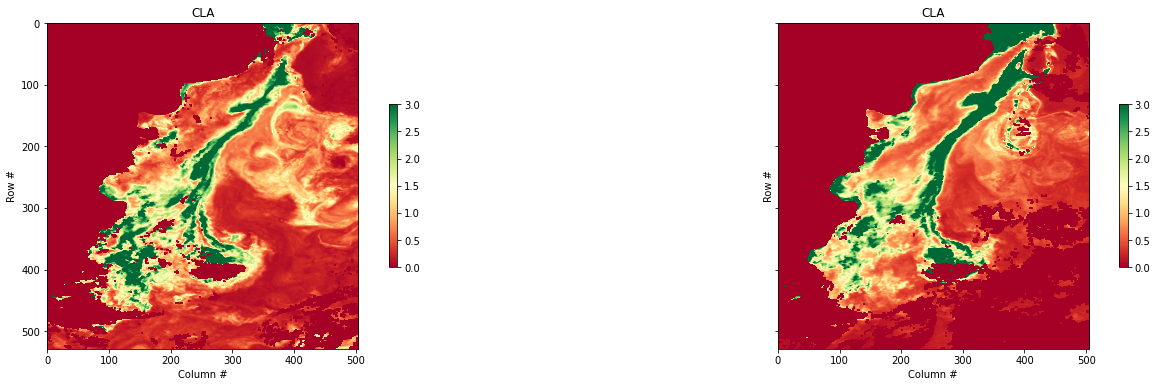

In [24]:
fig, axes = plt.subplots(1,2, figsize=(24,6), sharex=True, sharey=True)
plt.sca(axes[0])
plt.imshow(stackCLA[1], cmap='RdYlGn', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(stackCLA[2], cmap='RdYlGn', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

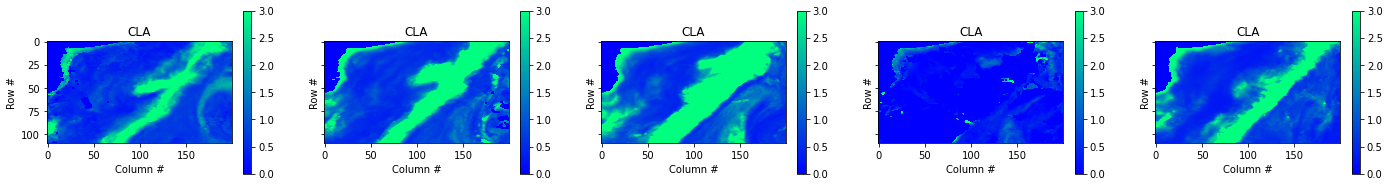

In [25]:
#Recorte del area de estudio 
fig, axes = plt.subplots(1,5, figsize=(24,6), sharex=True, sharey=True)
plt.sca(axes[0])
plt.imshow(stackCLA[1][90:200,200:400], cmap='winter', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(stackCLA[2][90:200,200:400], cmap='winter', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[2])
plt.imshow(stackCLA[4][90:200,200:400], cmap='winter', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[3])
plt.imshow(stackCLA[5][90:200,200:400], cmap='winter', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[4])
plt.imshow(stackCLA[6][90:200,200:400], cmap='winter', vmin=0, vmax=3)
plt.colorbar(shrink=0.5)
plt.title('CLA')
plt.xlabel('Column #')
plt.ylabel('Row #')


In [28]:
# serie temporal
def get_fechas_L3(dir_in, ext='tif', verbose=True):  
#     
    '''
    extrae la lista ordenada de fechas de los archivos MODIS 
    de una carpeta dada por dir_in.
    El resultado es una lista de objetos tipo datetime.
    '''
    
    files = os.listdir(dir_in) #Listado
    # Filtrar únicamente los formatos de datos que me interesan
    files_with_ext = [f for f in files if f.lower().endswith(ext.lower())]
    files_with_ext.sort() #Organizar en orden ascendente
#     print(files_with_ext)
    sfechas = []
    for f in files_with_ext:
        l = f[4:11]
        sfechas.append(l) #Extraer las fechas
    fechas = []
    for f in sfechas:
        l_fecha = datetime.strptime(f, '%Y%j')
        fechas.append(l_fecha) #Fechas a formato datetime
    
    if verbose: print(f'Recolecté {len(fechas)} fechas entre {fechas[0]} y {fechas[-1]}.')
    
    return fechas

In [29]:
# Carpeta con distitas imagenes .nc
#dir_in ='./data/tp_final/grupo_8/raw_data/L3_nc/')
dir_in = './data/raw_data/L3_nc'
#dir_in ='./data/tp_final/grupo_8/raw_data/L3_tif/')
# dir_in = '../data/raw_data/L3_tif/'
fechas= get_fechas_L3(dir_in, ext='.tif', verbose=True)
fechas 

Recolecté 92 fechas entre 2020-01-10 00:00:00 y 2020-05-01 00:00:00.


[datetime.datetime(2020, 1, 10, 0, 0),
 datetime.datetime(2020, 1, 10, 0, 0),
 datetime.datetime(2020, 1, 10, 0, 0),
 datetime.datetime(2020, 1, 10, 0, 0),
 datetime.datetime(2020, 1, 11, 0, 0),
 datetime.datetime(2020, 1, 11, 0, 0),
 datetime.datetime(2020, 1, 12, 0, 0),
 datetime.datetime(2020, 1, 12, 0, 0),
 datetime.datetime(2020, 1, 20, 0, 0),
 datetime.datetime(2020, 1, 20, 0, 0),
 datetime.datetime(2020, 1, 21, 0, 0),
 datetime.datetime(2020, 1, 21, 0, 0),
 datetime.datetime(2020, 1, 21, 0, 0),
 datetime.datetime(2020, 1, 21, 0, 0),
 datetime.datetime(2020, 1, 22, 0, 0),
 datetime.datetime(2020, 1, 22, 0, 0),
 datetime.datetime(2020, 1, 30, 0, 0),
 datetime.datetime(2020, 1, 30, 0, 0),
 datetime.datetime(2020, 1, 31, 0, 0),
 datetime.datetime(2020, 1, 31, 0, 0),
 datetime.datetime(2020, 2, 1, 0, 0),
 datetime.datetime(2020, 2, 1, 0, 0),
 datetime.datetime(2020, 2, 1, 0, 0),
 datetime.datetime(2020, 2, 1, 0, 0),
 datetime.datetime(2020, 2, 9, 0, 0),
 datetime.datetime(2020, 2, 9,

# Extraemos una muestra en la plataforma media 

data_CLA = stackCLA[i][120:123,250:253]
![image](./images/imagen5.png)

,max,min,mean,std
2020-01-10,0.341512,0.000000,0.214889,0.129553
2020-01-10,0.341512,0.000000,0.214889,0.129553
2020-01-10,0.341512,0.000000,0.214889,0.129553
2020-01-10,0.341512,0.000000,0.214889,0.129553
2020-01-11,0.094176,0.035570,0.069368,0.016362
...,...,...,...,...
2020-04-30,0.916684,0.727770,0.835240,0.063043
2020-04-30,0.916684,0.727770,0.835240,0.063043
2020-04-30,0.916684,0.727770,0.835240,0.063043
2020-05-01,0.431373,0.200861,0.362996,0.066043


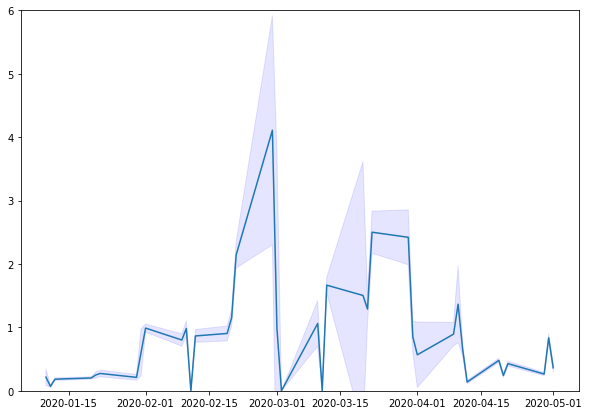

In [61]:
stackCLA[stackCLA<0]= 0

df = pd.DataFrame(index=fechas)# le agrego las columnas
df['max'] = 0.0
df['min'] = 0.0
df['mean'] = 0.0
df['std'] = 0.0

# calculo su contenido sacando los NANs
nodata = -32767
for i, fecha in enumerate(fechas):
    data_CLA = stackCLA[i][120:123,250:253] #subset 3x3 
    data_CLA = data_CLA[data_CLA!=nodata]
    df.loc[fecha,'max'] = data_CLA.max()
    df.loc[fecha,'min'] = data_CLA.min()
    df.loc[fecha,'mean'] = data_CLA.mean()
    df.loc[fecha,'std'] = data_CLA.std()

#Agregamos un desvío estandar 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
media_clase = df['mean'].values
std_clase = df['std'].values
ci = std_clase
ax.plot(fechas,media_clase)
ax.set_ylim(ymin=0,ymax=6)
ax.fill_between(fechas,media_clase-ci,(media_clase+ci), color='b', alpha=.1)

df